<a href="https://colab.research.google.com/github/ehersch/MNIST_Demo/blob/main/fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: The Fashion MNIST Dataset

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST.


This is like the MNIST dataset but a harder problem. A good CNN should get between 90-95% accuracy. This is what we will shoot for. See the MNIST demo for more documentation---this notebook will be more focused on improving performance.

https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html

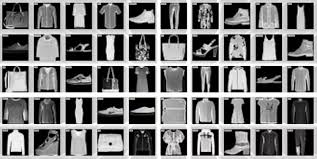

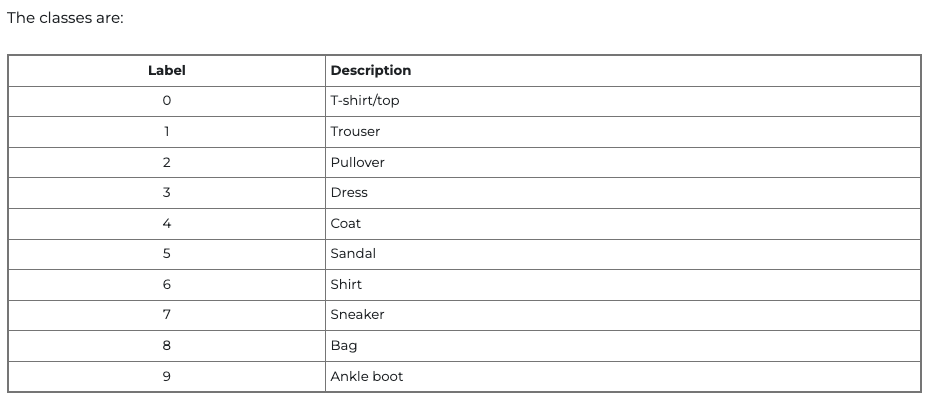

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt # for graphing
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 192kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.56MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.8MB/s]


In [4]:
item_map = {
    0:'T-shirt/top',
    1:'Trousers',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot'
}

In [5]:
class Model(nn.Module):
    def __init__(self, hidden_list, channels_list):
        super().__init__()

        assert channels_list[0] == 1, "channels_list must start with input channels = 1 for MNIST"

        def conv_block(in_channels, out_channels):
          """
            Creates a convolutional block of arbitrary channels for modularity.
          """
          return nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1),
              nn.ReLU(),
              nn.MaxPool2d(2, 2),
          )

        # leverage the splat operator * to unpack iterators
        self.features = nn.Sequential(
            *[
                conv_block(channels_list[i], channels_list[i + 1])
                for i in range(len(channels_list) - 1)
            ]
        )

        # infer feature size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            n_features = self.features(dummy).numel()

        def classifier_block(in_features, out_features):
          """
            Creates a classifier block of arbitrary hidden dimensions.
          """
          return nn.Sequential(
              nn.Linear(in_features, out_features),
              nn.ReLU(),
        )

        hidden_list = [n_features] + hidden_list # the first layer has n_features

        self.classifier = nn.Sequential(
            *[
                classifier_block(hidden_list[i], hidden_list[i + 1])
                for i in range(len(hidden_list) - 1)
            ],
            nn.Linear(hidden_list[-1], 10), # put the final prediction head on
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [6]:
def train(model, train_loader, optimizer, epochs):
    losses = []
    model.train() # good practice to keep even if not using BN or Dropout
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}\n-------------------------------")

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device) # move data over to same device as model (GPU when available)
            optimizer.zero_grad() # restart gradients
            y_pred = model(X)

            # multi-class classification problem where each image belongs to exactly one of 10 classes (digits 0–9).
            # The model outputs raw logits (one score per class), not probabilities.
            # CrossEntropyLoss is designed to work directly on logits, applying a LogSoftmax internally for numerical stability.
            loss = F.cross_entropy(y_pred, y)

            # loss.item() detaches the loss tensor item  from the computation graph
            # copies it to CPU if needed
            losses += [loss.item()] # use the item to get the float value (back on CPU)

            loss.backward()
            optimizer.step()
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_loader.dataset):>5d}]")

    return losses

In [7]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [8]:
model = Model([128], [1, 32, 64])

if torch.cuda.is_available():
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = train(model, train_loader=train_loader, optimizer=optimizer, epochs=10)


Epoch 1
-------------------------------
loss: 2.280829  [    0/60000]
loss: 0.604703  [ 6400/60000]
loss: 0.551355  [12800/60000]
loss: 0.512601  [19200/60000]
loss: 0.354183  [25600/60000]
loss: 0.681754  [32000/60000]
loss: 0.273272  [38400/60000]
loss: 0.391059  [44800/60000]
loss: 0.336086  [51200/60000]
loss: 0.301617  [57600/60000]

Epoch 2
-------------------------------
loss: 0.524071  [    0/60000]
loss: 0.439258  [ 6400/60000]
loss: 0.379020  [12800/60000]
loss: 0.530853  [19200/60000]
loss: 0.178881  [25600/60000]
loss: 0.343085  [32000/60000]
loss: 0.297429  [38400/60000]
loss: 0.258518  [44800/60000]
loss: 0.433376  [51200/60000]
loss: 0.344700  [57600/60000]

Epoch 3
-------------------------------
loss: 0.266760  [    0/60000]
loss: 0.321708  [ 6400/60000]
loss: 0.256252  [12800/60000]
loss: 0.225997  [19200/60000]
loss: 0.260014  [25600/60000]
loss: 0.397903  [32000/60000]
loss: 0.386535  [38400/60000]
loss: 0.234826  [44800/60000]
loss: 0.263328  [51200/60000]
loss: 0

In [9]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            outputs = model(X)                 # (batch_size, num_classes)
            preds = outputs.argmax(dim=1)      # predicted class indices

            correct += (preds == y).sum().item()
            total += y.size(0)

    print(f"Accuracy: {correct / total:.4f}")

In [10]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [11]:
evaluate(model, test_loader)

Accuracy: 0.9117


## To improve performance...

The Fashion MNIST dataset has more complexities than just digits. This could benefit from more convolutions (with more channels) to uncover more complexities. Try this with our modular CNN model.

Even with the sequential model (making it deeper), we saw performance capped at around 91.5%. We introduce some more tools to improve it:

- Deeper CNN
  - Perform 3 convolutional blocks with dimension [1, 32, 64, 128]
  - Make the hidden dimension 256 to account or this

- Change `conv_block`
  - Add `BatchNorm` to stabilize activations and speed convergence
  - Add `padding=1` to prevent shrinking when we add more layers

- Change `classifier_block`
  - Add dropout to the classifier (cheap regularization as we make the model larger)

In [29]:
class SequentialModel(nn.Module):
    def __init__(self, hidden_list, channels_list):
        super().__init__()

        assert channels_list[0] == 1, "channels_list must start with input channels = 1 for MNIST"

        def conv_block(in_channels, out_channels):
          """
            Creates a convolutional block of arbitrary channels for modularity.
          """
          return nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding = 1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(),
              nn.MaxPool2d(2, 2),
          )

        # leverage the splat operator * to unpack iterators
        self.features = nn.Sequential(
            *[
                conv_block(channels_list[i], channels_list[i + 1])
                for i in range(len(channels_list) - 1)
            ]
        )

        # infer feature size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            n_features = self.features(dummy).numel()

        def classifier_block(in_features, out_features):
          """
            Creates a classifier block of arbitrary hidden dimensions.
          """
          return nn.Sequential(
              nn.Linear(in_features, out_features),
              nn.ReLU(),
              nn.Dropout(p=0.3), # add slight dropout
        )

        hidden_list = [n_features] + hidden_list # the first layer has n_features

        self.classifier = nn.Sequential(
            *[
                classifier_block(hidden_list[i], hidden_list[i + 1])
                for i in range(len(hidden_list) - 1)
            ],
            nn.Linear(hidden_list[-1], 10), # put the final prediction head on
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

**Note, when training I found** width > depth for Fashion-MNIST. The dataset has limited spatial complexity and too much depth + pooling destroys information.

In [31]:
deeper_model = SequentialModel([256], [1, 32, 64, 128])
if torch.cuda.is_available():
    deeper_model.cuda()

train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
optimizer = optim.Adam(deeper_model.parameters(), lr=0.001)
losses = train(deeper_model, train_loader=train_loader, optimizer=optimizer, epochs=20)


Epoch 1
-------------------------------
loss: 2.376113  [    0/60000]
loss: 0.447582  [12800/60000]
loss: 0.365614  [25600/60000]
loss: 0.429210  [38400/60000]
loss: 0.247803  [51200/60000]

Epoch 2
-------------------------------
loss: 0.243075  [    0/60000]
loss: 0.228872  [12800/60000]
loss: 0.206166  [25600/60000]
loss: 0.271212  [38400/60000]
loss: 0.262781  [51200/60000]

Epoch 3
-------------------------------
loss: 0.212176  [    0/60000]
loss: 0.232690  [12800/60000]
loss: 0.179803  [25600/60000]
loss: 0.303462  [38400/60000]
loss: 0.182488  [51200/60000]

Epoch 4
-------------------------------
loss: 0.246208  [    0/60000]
loss: 0.168048  [12800/60000]
loss: 0.202398  [25600/60000]
loss: 0.135149  [38400/60000]
loss: 0.303668  [51200/60000]

Epoch 5
-------------------------------
loss: 0.250567  [    0/60000]
loss: 0.209261  [12800/60000]
loss: 0.164379  [25600/60000]
loss: 0.129198  [38400/60000]
loss: 0.179110  [51200/60000]

Epoch 6
-------------------------------
loss

In [32]:
evaluate(deeper_model, test_loader)

Accuracy: 0.9219


This improved performance! BatchNorm and dropout were useful as we made our networks **wider** to capture more features of the dataset.

In [42]:
deeper_model.eval()

with torch.no_grad():
    x, y = trainset[0]          # x: (1, 28, 28), y: scalar
    # x = x.unsqueeze(0)          # add batch dimension: (1, 28, 28) -> (1, 1, 28, 28)
    x = torch.einsum(
        'chw,b->bchw',
        x,
        torch.ones(1, device=x.device)
    ) # alternative: do this with einsum! (https://rockt.ai/2018/04/30/einsum)
    x = x.to(device)

    logits = deeper_model(x)
    pred = logits.argmax(dim=1).item()

print("Predicted:", item_map[pred])

Predicted: Ankle boot


In [33]:
torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=None)[0][0]


The image looks like an ankle boot!